In [190]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
#from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

In [191]:
df=pd.read_excel('samples_para_stress.xlsx')

In [192]:
df.columns

Index([     0.8806621611178381,       6.929460281685611,
             6.070214789084902,       5.090333131824253,
            1.9913069848705252,       5.955972360455448,
             5.801125666784954,      2.9238351824750968,
           0.18898669876261115,      1.5126641606671185,
            1.4572713593464723,     0.29564938827437465,
           0.21316954789073697, '0.21316954789073697.1',
            0.2402565869537286],
      dtype='object')

In [193]:
df.columns=['a','b','af','bf','as','bs','afs','bfs','gamma','sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']

In [194]:
df.describe()

a             b            af            bf            as  \
count  49999.000000  49999.000000  49999.000000  49999.000000  49999.000000   
mean       5.025083      5.049962      5.049980      5.049999      5.025060   
std        2.872315      2.857929      2.857938      2.857941      2.872343   
min        0.050039      0.100056      0.100077      0.100021      0.050098   
25%        2.537693      2.575004      2.574997      2.574997      2.537769   
50%        5.025121      5.049846      5.049926      5.049907      5.025032   
75%        7.512591      7.525040      7.525030      7.525009      7.512547   
max        9.999967      9.999993      9.999902      9.999956      9.999914   

                 bs           afs           bfs         gamma   sigma_fs_fs  \
count  49999.000000  49999.000000  49999.000000  49999.000000  49999.000000   
mean       5.049981      5.024984      5.050042      0.250501      6.002989   
std        2.857938      2.872373      2.857925      0.144052      7.699494   
min        0.100143      0.050022      0.100049      0.001003      0.001304   
25%        2.574972      2.537490      2.575016      0.125750      1.183854   
50%        5.049972      5.024963      5.050184      0.250505      3.232980   
75%        7.525016      7.512560      7.524976      0.375251      7.737697   
max        9.999931      9.999929      9.999894      0.499993     84.196017   

        sigma_sf_fs   sigma_fn_fn   sigma_nf_fn   sigma_ns_sn   sigma_sn_sn  
count  49999.000000  49999.000000  49999.000000  49999.000000  49999.000000  
mean       6.002710      3.191936      2.817805      2.817805      3.191656  
std        7.697265      4.702589      4.385529      4.385529      4.696326  
min        0.001304      0.000158      0.000158      0.000158      0.000158  
25%        1.183296      0.504343      0.421857      0.421857      0.507678  
50%        3.233874      1.544447      1.297485      1.297485      1.543375  
75%        7.734043      3.874724      3.299216      3.299216      3.879704  
max       84.900921     52.826732     52.197974     52.197974     54.382342

In [195]:
df.head(5)

a         b        af        bf        as        bs       afs  \
0  3.145409  1.666872  5.308194  7.532832  6.029283  0.435949  4.685014   
1  5.928295  3.858229  7.181880  6.581534  5.270250  9.749043  1.044398   
2  6.720615  2.550139  4.512333  7.554047  8.392858  9.420132  2.314248   
3  7.667194  4.451551  4.247710  9.656474  7.709719  2.519522  0.545103   
4  4.871057  2.721771  6.067258  7.333355  7.684224  1.565276  3.031701   

        bfs     gamma  sigma_fs_fs  sigma_sf_fs  sigma_fn_fn  sigma_nf_fn  \
0  6.931261  0.014293     0.112062     0.112066     0.045004     0.044973   
1  9.374484  0.300580     3.668962     3.567315     2.936709     2.525103   
2  0.447361  0.412720     6.103368     6.864435     5.072604     4.282678   
3  6.954437  0.331013     4.866012     5.096440     4.479420     4.133427   
4  3.486105  0.496787    10.623155    10.370392     7.062691     4.737183   

   sigma_ns_sn  sigma_sn_sn  
0     0.044973     0.045008  
1     2.525103     2.835062  
2     4.282678     5.833670  
3     4.133427     4.709848  
4     4.737183     6.809928

In [196]:
feature_columns=['sigma_fs_fs','sigma_sf_fs','sigma_fn_fn','sigma_nf_fn','sigma_ns_sn','sigma_sn_sn']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

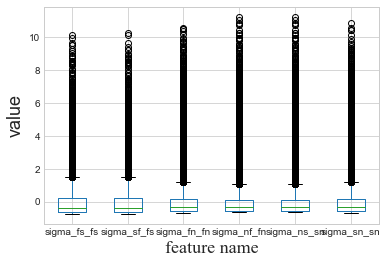

In [197]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [198]:
def box_plot_outliers(data_ser, box_scale):
    """
    remove some outliers
    :param data_ser: pandas.Series
    :param box_scale: the scale，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + 1.5*iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)
  

In [199]:
error_index = []
for col in feature_columns:
    error_index += box_plot_outliers(df[col],box_scale=-0.0019)
df=df.drop(error_index)

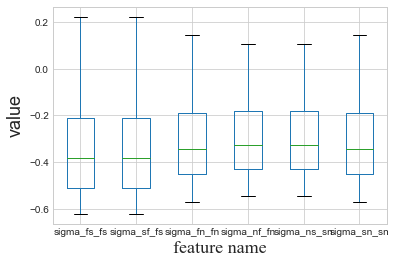

In [200]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [201]:
print(len(error_index))
data_ser = df[feature_columns[0]]
box_scale = -0.0019
iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
val_up = data_ser.quantile(0.75) + 1.5*iqr

print(val_up)


150841
0.24029890172257634


In [202]:
q_data,y_data=df.iloc[:,0:9],df.iloc[:,9]


###################################
print(q_data,y_data)

              a         b        af        bf        as        bs       afs  \
1      5.928295  3.858229  7.181880  6.581534  5.270250  9.749043  1.044398   
6      2.168220  5.778664  4.951038  0.524014  8.332374  4.120968  8.899819   
12     2.590232  2.292887  9.655192  2.681692  3.459277  4.414371  6.072245   
15     2.320295  4.676581  4.907614  9.008536  4.460376  6.941400  0.126673   
18     3.533415  1.316824  1.051073  4.378641  4.200044  5.647825  1.374685   
...         ...       ...       ...       ...       ...       ...       ...   
49985  8.116797  1.024812  7.856274  2.269605  5.464966  2.060914  1.853395   
49988  9.124533  5.081242  9.542328  0.158582  2.540038  0.627690  7.926885   
49989  3.714572  4.829624  0.366070  1.588599  1.202702  6.917243  5.712759   
49992  9.048329  5.878545  0.102261  9.647968  0.757986  8.356967  5.542130   
49994  1.769335  2.584496  5.400948  0.842568  2.223979  4.110529  1.637511   

            bfs     gamma  
1      9.374484  0.3005

In [203]:
train_size=int(0.9*len(q_data))

In [204]:
q_data_train,q_data_test=q_data.iloc[:train_size],q_data.iloc[train_size:]
y_data_train,y_data_test=y_data.iloc[:train_size],y_data.iloc[train_size:]

In [205]:
print(q_data_train)
print(y_data_train)

              a         b        af        bf        as        bs       afs  \
1      5.928295  3.858229  7.181880  6.581534  5.270250  9.749043  1.044398   
6      2.168220  5.778664  4.951038  0.524014  8.332374  4.120968  8.899819   
12     2.590232  2.292887  9.655192  2.681692  3.459277  4.414371  6.072245   
15     2.320295  4.676581  4.907614  9.008536  4.460376  6.941400  0.126673   
18     3.533415  1.316824  1.051073  4.378641  4.200044  5.647825  1.374685   
...         ...       ...       ...       ...       ...       ...       ...   
45000  5.420018  2.627239  9.940668  2.462836  6.955668  2.025012  5.497136   
45001  6.943231  3.465796  6.063006  9.727705  0.308608  3.330534  6.610824   
45002  5.074779  2.810202  1.118246  8.465789  5.002698  6.355877  2.168242   
45010  1.514281  5.542378  3.633517  8.793757  1.238548  3.965432  5.085510   
45011  7.914420  1.296344  5.152824  0.892272  2.956342  5.188668  3.585432   

            bfs     gamma  
1      9.374484  0.3005

In [206]:
print(q_data_test)

              a         b        af        bf        as        bs       afs  \
45012  5.357008  6.250978  4.636275  2.138783  2.685147  0.560359  5.396892   
45017  6.368584  6.812532  3.686664  7.337701  2.865569  2.449156  5.098483   
45021  1.632936  7.295925  4.632789  6.230595  1.871144  5.391924  1.109966   
45024  1.966451  6.267214  0.529913  8.930765  9.143841  2.356918  0.236874   
45026  1.432564  3.111481  2.277022  2.011149  3.608140  2.906718  3.201698   
...         ...       ...       ...       ...       ...       ...       ...   
49985  8.116797  1.024812  7.856274  2.269605  5.464966  2.060914  1.853395   
49988  9.124533  5.081242  9.542328  0.158582  2.540038  0.627690  7.926885   
49989  3.714572  4.829624  0.366070  1.588599  1.202702  6.917243  5.712759   
49992  9.048329  5.878545  0.102261  9.647968  0.757986  8.356967  5.542130   
49994  1.769335  2.584496  5.400948  0.842568  2.223979  4.110529  1.637511   

            bfs     gamma  
45012  9.859100  0.1163

In [207]:
#q_data_exp,y_data_exp=q_data.iloc[-1,:].values.reshape((1,-1)),y_data.iloc[-1,:].values.reshape((1,-1))
#print(y_data_exp)

In [208]:
q_data_train.shape,q_data_test.shape

((16612, 9), (1846, 9))

In [209]:
#q_data_exp

In [210]:
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [211]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [212]:
X.shape,y.shape,X_test.shape,y_test.shape

((16612, 9), (16612,), (1846, 9), (1846,))

In [213]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [214]:
## not yet finished
kernel = RBF(length_scale= 50, length_scale_bounds=(0.0,100))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(1):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y)
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)

fitting feature 0
RBF(length_scale=3.98)


In [215]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(1):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    pred = gpr_sub.predict(X)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y, pred),metrics.r2_score(y, pred)))

fitting feature 0
gpr Test: mse loss=0.000000 r2_score=1.000000


Text(0.5, 1.0, 'feature 1')

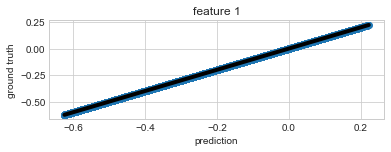

In [219]:
plt.style.use('seaborn-whitegrid')
plt.subplot(2,1,1)
feat_flag = 0;
feature_min = min(pred)
feature_max = max(pred)
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(pred, y, marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

In [217]:

for feat_flag in range(1):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    y_pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test, y_pred),metrics.r2_score(y_test, y_pred)))


fitting feature 0
gpr Test: mse loss=0.007342 r2_score=0.825867


Text(0.5, 1.0, 'feature 1')

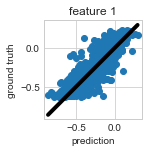

In [220]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred)
feature_max = max(y_pred)
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred, y_test, marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()



In [ ]:
from xgboost import XGBRegressor